In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *
from tomopt.plotting import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


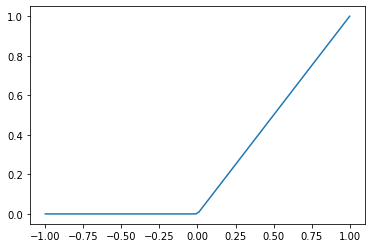

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.2
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.6,0.4]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.D

# Data

In [7]:
from tomopt.optimisation.data.passives import AbsPassiveGenerator
from typing import *
from random import shuffle

class FixedBlockPassiveGenerator(AbsPassiveGenerator):
    def generate(self) -> Callable[..., Tensor]:
        i = np.random.randint(0,len(self.materials))
        
        def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
            return torch.ones(list((lw/size).long()))*X0[self.materials[i]]
        
        return arb_rad_length, i

In [8]:
FixedBlockPassiveGenerator().generate()[0](z=0.8, lw=volume.lw, size=volume.passive_size)

tensor([[0.0056, 0.0056, 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056, 0.0056, 0.0056]])

In [9]:
from lumin.nn.data.fold_yielder import FoldYielder

class ScatterYielder(FoldYielder):
    def __init__(self, volume:Volume, passive_generator:FixedBlockPassiveGenerator, mu_bs:int, n_volumes_per_fold:int, targ_as_class:bool):
        self.cont_feats,self.cat_feats,self.input_pipe,self.output_pipe = [],[],None,None
        self.yield_matrix,self.matrix_pipe = True,None
        self.augmented,self.aug_mult,self.train_time_aug,self.test_time_aug = False,0,False,False
        self.input_feats = self.cont_feats + self.cat_feats
        self.orig_cont_feats,self.orig_cat_feat,self._ignore_feats = self.cont_feats,self.cat_feats,[]
        
        self.volume,self.passive_generator,self.mu_bs = volume,passive_generator,mu_bs
        self.voxel_centres = self._build_centres()
        self.targ_as_class = targ_as_class
        if self.targ_as_class:
            self.class2id = {m:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2class = {i:m for i,m in enumerate(self.passive_generator.materials)}
            self.x02id = {X0[m]:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2x0 = {i:X0[m] for i,m in enumerate(self.passive_generator.materials)}
                
        self.n_volumes_per_fold = n_volumes_per_fold
        self.n_voxels = int(len(self.volume.get_passives())*(self.volume.lw/self.volume.passive_size).prod().item())
        self.n_folds = 10
        self.has_matrix = True
        self.fld_szs = {i:self.n_volumes_per_fold for i in range(self.n_folds)}
        
        self.targ_feats = ["X0"]
        self.matrix_feats = {'present_feats': ["dtheta_x", "dtheta_y", "dx", "dy", "pred_x0", "dpoca_x", "dpoca_y", "dpoca_z", "dpoca_r"],
                             'vecs': [f'mu_{i}' for i in range(self.mu_bs)], 'missing': [], 'row_wise': True}
        self.matrix_feats['feats_per_vec'] = len(self.matrix_feats['present_feats']), 
        self.matrix_feats['shape'] = (self.mu_bs, self.matrix_feats['feats_per_vec'])
        self.matrix_is_sparse = False
        self.matrix_shape = self.matrix_feats['shape']
        
    def _build_centres(self) -> Tensor:
        bounds = (
            self.volume.passive_size
            * np.mgrid[
                round(self.volume.get_passive_z_range()[0].detach().cpu().numpy()[0] / self.volume.passive_size) : round(
                      self.volume.get_passive_z_range()[1].detach().cpu().numpy()[0] / self.volume.passive_size
                ) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[0] / self.volume.passive_size) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[1] / self.volume.passive_size) : 1,
            ]
        )
#         bounds[0] = np.flip(bounds[0])  # z is reversed
        return torch.tensor(bounds.reshape(3, -1).transpose(-1, -2), dtype=torch.float32) + (self.volume.passive_size/2)
        
    def generate_data(self) -> Dict[str, np.ndarray]:
        inputs,targets = [],[]
        for _ in range(self.n_volumes_per_fold):
            #Scatter generation
            muons = MuonBatch(generate_batch(self.mu_bs), self.volume.h, device=self.volume.device)
            block, targ = self.passive_generator.generate()
            self.volume.load_rad_length(block)
            self.volume(muons)
            sb = GenScatterBatch(muons, self.volume)
            
            # x0 prediction
            mom = muons.reco_mom
            dtheta = sb.dtheta
            theta_xy_in = sb.theta_in
            theta_xy_out = sb.theta_out
            theta2 = dtheta.pow(2).sum(1)
            n_x0 = 0.5 * theta2 * ((mom / SCATTER_COEF_A) ** 2)
            theta_in = theta_xy_in.pow(2).sum(1).sqrt()
            theta_out = theta_xy_out.pow(2).sum(1).sqrt()
            cos_theta_in = torch.cos(theta_in)
            cos_theta_out = torch.cos(theta_out)
            cos_mean = (cos_theta_in + cos_theta_out) / 2
            pred = self.volume.passive_size / (n_x0 * cos_mean)
            
            #Data creation
            data = torch.cat((sb.dtheta, sb.dxy, pred[:,None], sb.location), dim=-1).detach()
            data = data[None,:].repeat_interleave(len(self.voxel_centres), dim=0)
            data[:,:,-3:] -= self.voxel_centres[:,None].repeat_interleave(self.mu_bs, dim=1)
            data = torch.cat((data,torch.norm(data[:,:,-3:], dim=-1, keepdim=True)), dim=-1)  # dR
            
            # Sort by dR
            idxs = data[:,:,-1].argsort()
            i = np.arange(data.shape[0])[:,None]
            data = data[i,idxs]
            
            inputs.append(data[None,:])
            targets.append(targ)
        
        inputs = torch.cat(inputs, dim=0).detach().cpu().numpy()
        targets = np.array(targets)[:,None]
        if self.targ_as_class:
            for m in self.passive_generator.materials:
                targets[targets == X0[m]] = self.class2id[m]
            targets = targets.astype(int)
        return {'inputs':(np.zeros((len(inputs),0)),inputs),'targets':targets}
        
    def get_fold(self, idx:int) -> Dict[str,np.ndarray]:
        return self.generate_data()

In [10]:
sy = ScatterYielder(volume=volume, passive_generator=FixedBlockPassiveGenerator(materials=['beryllium', "silicon", 'iron', 'lead']), mu_bs=100, n_volumes_per_fold=160, targ_as_class=True)

In [11]:
sy.n_voxels

75

In [12]:
fold = sy[0]
fold['inputs'][1].shape,fold['targets'].shape

((160, 75, 100, 9), (160, 1))

In [13]:
fold['inputs'][1][0,0,:,-1]

array([0.26778063, 0.30781135, 0.31700197, 0.3358921 , 0.3600189 ,
       0.36493912, 0.3744142 , 0.37533838, 0.39939535, 0.40707314,
       0.423921  , 0.43830907, 0.45735276, 0.49095124, 0.49148145,
       0.4921813 , 0.49247286, 0.49987108, 0.5070053 , 0.52183354,
       0.53744376, 0.55048424, 0.5568261 , 0.5778242 , 0.58066005,
       0.5920382 , 0.5929032 , 0.6182259 , 0.6245519 , 0.6260959 ,
       0.6360607 , 0.6436233 , 0.6529825 , 0.69896054, 0.70063823,
       0.70668834, 0.71493334, 0.7180387 , 0.72489476, 0.72981524,
       0.73391044, 0.73539066, 0.7387787 , 0.74053806, 0.74692154,
       0.76139486, 0.77933574, 0.7851108 , 0.80012006, 0.8114372 ,
       0.8148482 , 0.8239552 , 0.83616066, 0.83812267, 0.84436774,
       0.84554726, 0.850626  , 0.85257137, 0.8696665 , 0.87532985,
       0.8773547 , 0.88236505, 0.8837105 , 0.884824  , 0.89833325,
       0.8997339 , 0.9019693 , 0.92109   , 0.9220473 , 0.9241184 ,
       0.93798506, 0.9532011 , 0.95774484, 0.9593539 , 0.97962

In [14]:
fold['targets']

array([[2],
       [1],
       [1],
       [2],
       [2],
       [3],
       [2],
       [0],
       [3],
       [1],
       [2],
       [3],
       [3],
       [1],
       [0],
       [1],
       [2],
       [0],
       [2],
       [1],
       [1],
       [3],
       [3],
       [3],
       [0],
       [2],
       [3],
       [2],
       [0],
       [0],
       [2],
       [1],
       [1],
       [0],
       [2],
       [3],
       [3],
       [2],
       [0],
       [2],
       [3],
       [1],
       [3],
       [1],
       [3],
       [2],
       [0],
       [1],
       [0],
       [3],
       [3],
       [1],
       [0],
       [3],
       [1],
       [3],
       [2],
       [3],
       [2],
       [3],
       [3],
       [3],
       [1],
       [0],
       [2],
       [1],
       [1],
       [3],
       [0],
       [0],
       [2],
       [0],
       [2],
       [3],
       [2],
       [3],
       [2],
       [1],
       [0],
       [1],
       [2],
       [2],
       [0],
    

# Classifier

In [15]:
from lumin.nn.models.blocks.head import *
from lumin.nn.models.blocks.head import AbsGraphFeatExtractor
from lumin.nn.models.blocks.gnn_blocks import *
from lumin.nn.models.initialisations import lookup_normal_init
from lumin.nn.models.layers.activations import lookup_act
from lumin.nn.models.layers.batchnorms import RunningBatchNorm1d, LCBatchNorm1d, RunningBatchNorm2d

from torch._vmap_internals import _vmap as vmap

class X0Net(AbsGraphFeatExtractor):
    row_wise:Optional[bool] = True
        
    def __init__(self, n_v:int, n_fpv:int, vox_centres:Tensor,
                 do:float=0, rep_bn:bool=False, act:str='relu',
                 lookup_init:Callable[[str,Optional[int],Optional[int]],Callable[[Tensor],None]]=lookup_normal_init,
                 lookup_act:Callable[[str],Any]=lookup_act, bn_class:Callable[[int],nn.Module]=nn.BatchNorm1d, rep_bn_class:Callable[[int],nn.Module]=nn.BatchNorm2d):
        super().__init__(n_v=n_v, n_fpv=n_fpv, do=do, bn=False, act=act, lookup_init=lookup_init, lookup_act=lookup_act, bn_class=bn_class)
        
        self.n_voxels,self.rep_bn,self.rep_bn_class = len(vox_centres),rep_bn,rep_bn_class
                
        # GNNs
        if self.rep_bn: self.init_bn = self.rep_bn_class(self.n_fpv)
        
        self.n_muon_rep, self.n_vox_rep = 40, 40
        self.muon_rep_gnn = GravNet(n_v=self.n_v, n_fpv=self.n_fpv,
                                    cat_means=True,
                                    f_slr_depth=3,
                                    n_s=4,
                                    n_lr=22,
                                    k=25,
                                    f_out_depth=1,
                                    n_out=[48],
                                    act=self.act,
                                    use_sa=False,
                                    bn=False,
                                   )
        self.muon_rep_collapser = GraphCollapser(n_v=self.n_v, n_fpv=self.muon_rep_gnn.get_out_size()[1],
                                                 flatten=False,
                                                 f_final_outs=[self.n_muon_rep],
                                                 n_sa_layers=0,
                                                 global_feat_vec=False,
                                                 act=self.act,
                                                 bn=False,
                                                )
        
        if self.rep_bn: self.muon_rep_bn = self.rep_bn_class(self.muon_rep_collapser.get_out_size()+4)
        
        self.vox_rep_gnn = GravNet(n_v=self.n_voxels, n_fpv=self.muon_rep_collapser.get_out_size()+4,
                                   cat_means=True,
                                   f_slr_depth=3,
                                   n_s=4,
                                   n_lr=22,
                                   k=12,
                                   f_out_depth=1,
                                   n_out=[48],
                                   act=self.act,
                                   use_sa=False,
                                   bn=False,
                                  )
        self.vox_rep_collapser = GraphCollapser(n_v=self.n_voxels, n_fpv=self.vox_rep_gnn.get_out_size()[1],
                                                flatten=False,
                                                f_final_outs=[self.n_vox_rep],
                                                n_sa_layers=0,
                                                global_feat_vec=False,
                                                act=self.act,
                                                bn=False,
                                               )
        
        # Relative voxel positions
        self.vox_centres = vox_centres  # (voxel,coords)
        vox_dists = self.vox_centres[None]-self.vox_centres[:,None]  # (voxel,voxel,coords)
        self.register_buffer('vox_dists', torch.cat((vox_dists,vox_dists.norm(dim=-1, keepdim=True)), dim=-1))
        
    def forward(self, x:Tensor) -> Tensor:
        r'''x=(volume,voxel,muon,feature)'''
        if self.rep_bn: x = self.init_bn(x.transpose(1,-1)).transpose(1,-1)
        
        def get_muon_rep(x:Tensor) -> Tensor:
            r'''(voxel,muon,feature)'''
            return self.muon_rep_collapser(self.muon_rep_gnn(x))
        
#         muon_rep = vmap(get_muon_rep)(x)  # (volume,voxel,muon_rep)
        muon_rep = torch.stack([get_muon_rep(v) for v in x.unbind()], dim=0)  # (volume,voxel,muon_rep)
        muon_rep = muon_rep[:,None].expand(-1,self.n_voxels, -1,-1)  # (volume,voxel,voxel,muon_rep)
        muon_rep = torch.cat((muon_rep, self.vox_dists[None].expand(len(muon_rep), -1, -1, -1)), dim=-1)
        if self.rep_bn: muon_rep = self.muon_rep_bn(muon_rep.transpose(1,-1)).transpose(1,-1)
        
        def get_vox_rep(x:Tensor) -> Tensor:
            r'''(voxel,voxel,muon_rep)'''
            return self.vox_rep_collapser(self.vox_rep_gnn(x))
        
#         vox_rep = vmap(get_vox_rep)(muon_rep)  # (volume,voxel,class)
        vox_rep = torch.stack([get_vox_rep(v) for v in muon_rep.unbind()], dim=0)  # (volume,voxel,class)
        return vox_rep
    
    def get_out_size(self) -> Tuple[int,int]: return self.n_voxels, self.n_vox_rep*2

In [16]:
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.optimisation.hyper_param import lr_find

head = partial(GNNHead, vecs=sy.matrix_feats['vecs'], feats_per_vec=sy.matrix_feats['present_feats'],
               extractor=partial(X0Net, vox_centres=sy.voxel_centres, rep_bn=True, rep_bn_class=RunningBatchNorm2d, act='swish'),
               collapser=partial(GraphCollapser,
                                 flatten=True,
                                 f_final_outs=[10],
                                 bn=False,
                                 act='swish',
                                 bn_class=RunningBatchNorm1d
                                ))

body = partial(FullyConnected, depth=3, width=50, act='swish')
opt_args = {'opt':'adam', 'eps':1e-08}
model_builder = ModelBuilder('multiclass', cont_feats=sy.matrix_feats['present_feats'], n_out=len(sy.passive_generator.materials), 
                             opt_args=opt_args, body=body, head=head)
print(Model(model_builder))

Inputs:
9 Continuous: ['dtheta_x', 'dtheta_y', 'dx', 'dy', 'pred_x0', 'dpoca_x', 'dpoca_y', 'dpoca_z', 'dpoca_r']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): GNNHead(
    (extractor): X0Net(
      (init_bn): RunningBatchNorm2d()
      (muon_rep_gnn): GravNet(
        (grav_layers): ModuleList(
          (0): GravNetLayer(
            (f_slr): Sequential(
              (0): Sequential(
                (0): Linear(in_features=18, out_features=52, bias=True)
                (1): Swish()
              )
              (1): Sequential(
                (0): Linear(in_features=52, out_features=52, bias=True)
                (1): Swish()
              )
              (2): Sequential(
                (0): Linear(in_features=52, out_features=26, bias=True)
                (1): Swish()
              )
            )
            (f_out): Sequential(
              (0): Sequential(
 

In [17]:
sy.get_data_count(0)

160

LR finder took 121.845s 


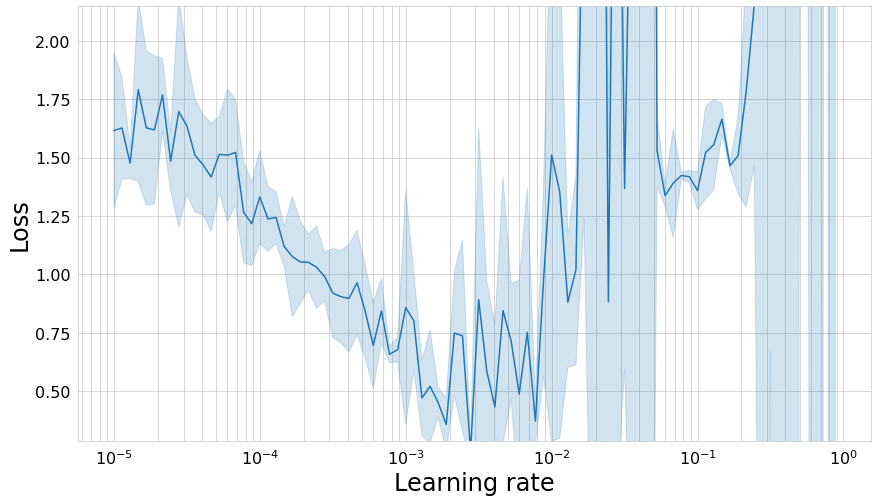

In [18]:
lr_finder = lr_find(sy, model_builder, bs=16, lr_bounds=[1e-5,1e0], n_repeats=3, bulk_move=False)

In [19]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from lumin.nn.metrics.class_eval import RocAucScore
from functools import partial

cb_partials = [partial(OneCycle, lengths=[5, 10],lr_range=[1e-5, 1e-3], mom_range=[0.85, 0.95], interp='cosine')]
metric_partials = (partial(RocAucScore, average='weighted', multi_class='ovr'))

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


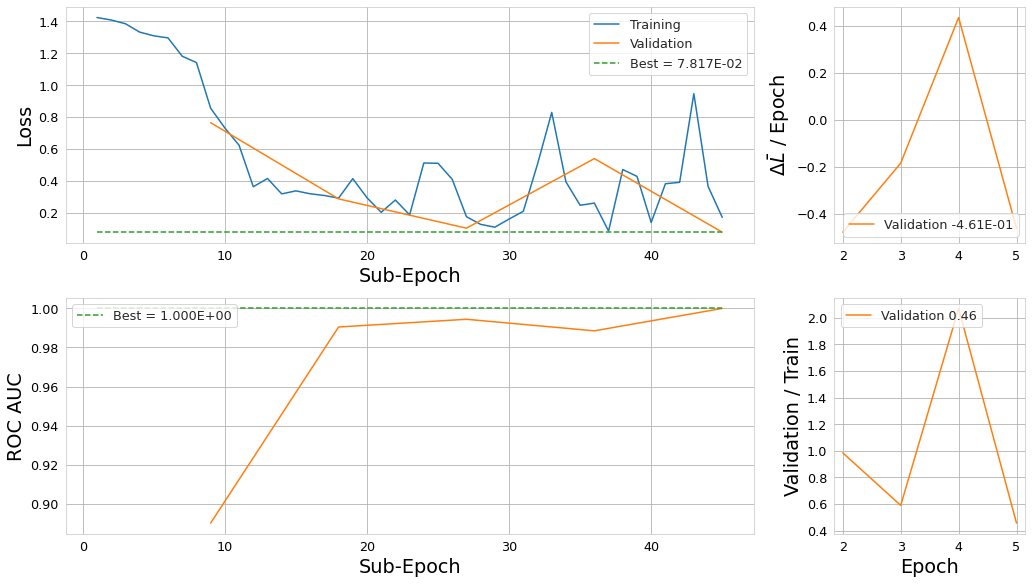

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/centos/volume/anaconda3/envs/tomopt/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-04e07160a487>", line 2, in <module>
    _ = train_models(sy, n_models=1,
  File "/home/centos/volume/lumin/lumin/nn/training/train.py", line 130, in train_models
    model.fit(n_epochs=n_epochs, fy=fy, bs=bs, bulk_move=bulk_move, train_on_weights=train_on_weights, trn_idxs=trn_idxs, val_idx=val_idx,
  File "/home/centos/volume/lumin/lumin/nn/models/model.py", line 222, in fit
    fit_epoch()
  File "/home/centos/volume/lumin/lumin/nn/models/model.py", line 200, in fit_epoch
    self.fit_params.by = trn_by(**self.fit_params.fy.get_fold(self.fit_params.trn_idx))
  File "<ipython-input-9-f7a822d82ba8>", line 95, in get_fold
    return self.generate_data()
  File "<ipython-input-9-f7a822d82ba8>", line 76, in generate_data
    data = torch.cat(

TypeError: object of type 'NoneType' has no len()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f0d413ee790> (for post_execute):


KeyboardInterrupt: 

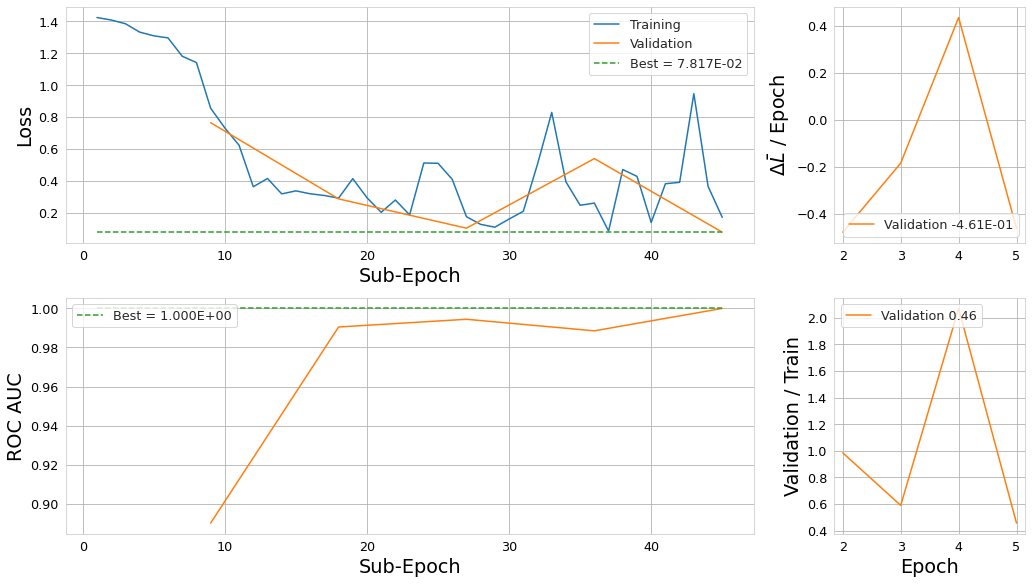

In [20]:
from lumin.nn.training.train import train_models
_ = train_models(sy, n_models=1,
                 model_builder=model_builder,
                 bs=16,
                 cb_partials=cb_partials,
                 metric_partials=metric_partials,
                 n_epochs=15,
                 bulk_move=False)

In [21]:
model = Model.from_save('train_weights/model_id_0/best.h5', model_builder)

In [22]:
data = sy[0]

In [23]:
pred = model.predict(data['inputs'])

In [24]:
pred

array([[6.07391581e-10, 4.25623634e-11, 1.74677535e-08, 1.00000000e+00],
       [9.49900031e-01, 4.77835424e-02, 3.14667384e-04, 2.00173352e-03],
       [9.28643334e-04, 2.34244484e-03, 9.94978309e-01, 1.75055035e-03],
       [6.58753933e-03, 1.26673402e-02, 9.71588492e-01, 9.15660150e-03],
       [3.04060310e-09, 2.51648175e-10, 6.73417873e-08, 9.99999940e-01],
       [1.35903046e-01, 8.32616508e-01, 7.48730730e-03, 2.39930935e-02],
       [6.96033897e-10, 5.91637156e-11, 2.04341468e-08, 1.00000000e+00],
       [1.57785820e-07, 4.04950065e-08, 2.13616477e-06, 9.99997735e-01],
       [1.53911133e-05, 3.52527672e-06, 1.20338176e-04, 9.99860585e-01],
       [1.96381852e-01, 7.64272928e-01, 7.78615056e-03, 3.15590836e-02],
       [1.31949701e-03, 2.85582594e-03, 9.93476450e-01, 2.34833104e-03],
       [1.41152539e-08, 2.15196105e-09, 2.57710326e-07, 9.99999702e-01],
       [1.14852283e-09, 6.47892920e-11, 3.57513130e-08, 1.00000000e+00],
       [3.26914757e-01, 5.86424172e-01, 2.15575658e

In [25]:
data['inputs'][1][0,0]

array([[ 1.71994716e-02,  3.64243835e-02, -6.21815503e-04,
        -2.96204438e-04,  1.87574420e-03, -6.98700994e-02,
         4.95363846e-02,  2.62692571e-01,  2.76302516e-01],
       [ 3.93311679e-03,  2.19284110e-02,  3.85533250e-03,
         7.06309220e-04,  6.03669602e-03, -2.47137308e-01,
        -5.96739352e-02,  1.21984728e-01,  2.81989545e-01],
       [ 2.26326287e-03,  1.18861869e-02,  1.49150542e-03,
         2.86371593e-04,  2.03943178e-02,  3.05643499e-01,
         7.16931000e-02, -8.94639641e-03,  3.14066708e-01],
       [ 1.16195362e-02,  1.80207398e-02,  1.96841941e-03,
         1.26852817e-03,  6.44190330e-03,  2.25464761e-01,
         1.90127015e-01,  1.71408653e-01,  3.41121048e-01],
       [ 5.28288186e-02,  1.22636557e-05, -3.07568780e-06,
         1.30346976e-02,  1.07002328e-03, -2.36981168e-01,
        -1.79561228e-03,  2.84253418e-01,  3.70085537e-01],
       [ 9.47730988e-03,  3.36347520e-03,  1.08013675e-03,
         3.04413959e-03,  2.97444258e-02,  1.362749

In [26]:
pred_class = pred.argmax(-1)
# pred_class = pred > 0.5

In [27]:
pred_class

array([3, 0, 2, 2, 3, 1, 3, 3, 3, 1, 2, 3, 3, 1, 2, 0, 1, 0, 2, 2, 3, 1,
       0, 0, 3, 3, 1, 3, 0, 2, 0, 1, 2, 1, 1, 2, 2, 3, 2, 3, 0, 3, 2, 2,
       0, 1, 3, 2, 1, 2, 3, 2, 1, 1, 2, 2, 1, 3, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 3, 1, 1, 1, 0, 3, 0, 2, 2, 0, 2, 0, 2, 3, 0, 0, 3, 0, 2, 3, 3,
       2, 2, 1, 0, 0, 3, 0, 1, 1, 2, 2, 0, 0, 0, 3, 3, 3, 1, 3, 3, 3, 2,
       1, 0, 2, 3, 3, 1, 1, 2, 3, 0, 3, 3, 3, 2, 1, 2, 3, 3, 1, 0, 1, 0,
       1, 2, 0, 2, 1, 3, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 2, 0, 3,
       1, 2, 1, 3, 0, 1])

In [28]:
targs = data['targets'].flatten()

In [29]:
targs

array([3, 0, 2, 2, 3, 1, 3, 3, 3, 1, 2, 3, 3, 1, 2, 0, 1, 0, 2, 2, 3, 1,
       0, 0, 3, 3, 1, 3, 0, 2, 0, 1, 2, 1, 1, 2, 2, 3, 2, 3, 0, 3, 2, 2,
       0, 1, 3, 2, 1, 2, 3, 2, 1, 1, 2, 2, 1, 3, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 3, 1, 1, 1, 0, 3, 0, 2, 2, 0, 2, 0, 2, 3, 0, 0, 3, 0, 2, 3, 3,
       2, 2, 1, 0, 0, 3, 0, 1, 1, 2, 2, 0, 0, 0, 3, 3, 3, 1, 3, 3, 3, 2,
       1, 0, 2, 3, 3, 1, 1, 2, 3, 0, 3, 3, 3, 2, 1, 2, 3, 3, 1, 0, 1, 0,
       1, 2, 0, 2, 1, 3, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 2, 0, 3,
       1, 2, 1, 3, 0, 1])

In [30]:
from sklearn.metrics import confusion_matrix, roc_auc_score

In [31]:
confusion_matrix(targs, pred_class)

array([[35,  0,  0,  0],
       [ 0, 42,  0,  0],
       [ 0,  0, 42,  0],
       [ 0,  0,  0, 41]])

In [32]:
roc_auc_score(y_true=targs, y_score=pred, multi_class='ovr', average='weighted')

1.0